<a href="https://colab.research.google.com/github/BJToor/sep769-deep-learning-project/blob/adam/DeepLearningProject_Group2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Project** - Aerial Perspective Object Detection
SEP 769 - Group 2

In [119]:

#About semantic segmentation: https://www.jeremyjordan.me/semantic-segmentation/
#TF Tutorial: https://www.tensorflow.org/tutorials/images/segmentation
#TF load and process images: https://www.tensorflow.org/tutorials/load_data/images
from google.colab.patches import cv2_imshow
import pandas as pd
from google.colab import drive
import tensorflow as tf
import tensorflow_datasets as tfds
drive.mount('/content/gdrive')
import cv2
import glob
import numpy as np
import os
import fnmatch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

if not os.path.exists("/content/gdrive/Shareddrives/SEP_769/data/drone_data/"):
  !unzip "/content/gdrive/Shareddrives/SEP_769/drone_data.zip" -d "/content/gdrive/Shareddrives/SEP_769/data"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Constants

In [29]:
original_images_path = '/content/gdrive/Shareddrives/SEP_769/data/drone_data/original_images/'
original_semantic_path = '/content/gdrive/Shareddrives/SEP_769/data/drone_data/label_images_semantic/'
colourmap_path = "/content/gdrive/Shareddrives/SEP_769/class_dict_seg.csv"
HEIGHT = 192
WIDTH = 320
EPOCHS = 40

#Functions

In [3]:
# reads images from dir, resizes and returns np array
# optional file type argument ext
def images_to_array(dir, width, height, ext='.jpg'):
  data = []
  files = os.listdir(dir)
  files.sort()
  for filename in files:
    if filename.endswith(ext):
      img = cv2.imread(dir + filename)
      img = cv2.resize(img, (width, height))
      data.append(img)

  return np.array(data)

In [4]:
# displays a number of originals with their masks
def display_images(images):
  plt.figure(figsize=(15,10))
  for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    if len(images[i].shape) == 3 and images[i].shape[2] > 1:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(images[i]))
    else:
      # plt.imshow(images[i], cmap="gray", vmin=0, vmax=255)
      plt.imshow(images[i], cmap="gray")
  plt.show()

In [132]:
def labels_to_colour(label):
  colourmap = pd.read_csv(colourmap_path)
  red = np.zeros((192,320))
  green = np.zeros((192,320))
  blue = np.zeros((192,320))
  for i in range(len(label)):
    for j in range(len(label[i])):
      red[i:i+1,j:j+1] = colourmap[" r"][label[i][j]]
      green[i:i+1,j:j+1] = colourmap[" g"][label[i][j]]
      blue[i:i+1,j:j+1] = colourmap[" b"][label[i][j]]
  result = np.dstack((blue,green,red))
  print(result.shape)
  return result

# Image Imports

In [5]:
images = images_to_array(original_images_path, width=WIDTH, height=HEIGHT)
print(images.shape)

(400, 192, 320, 3)


In [6]:
labels = images_to_array(original_semantic_path, width=WIDTH, height=HEIGHT, ext='png')
print(labels.shape)
labels = labels[:,:,:,1]
print(labels.shape)

(400, 192, 320, 3)
(400, 192, 320)


#Data Visualization

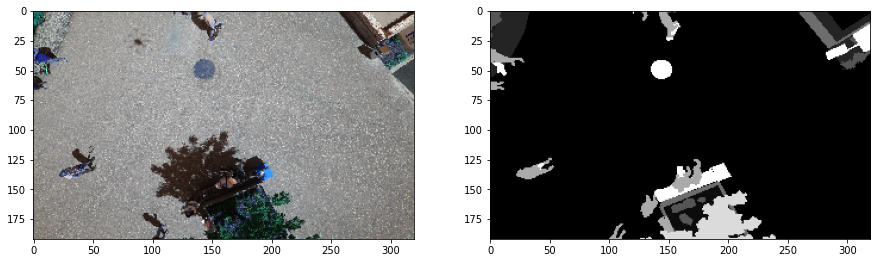

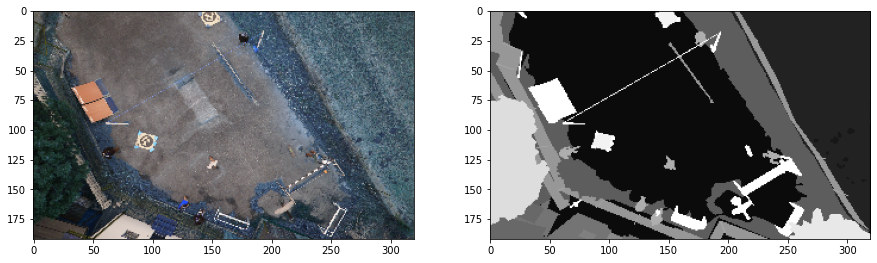

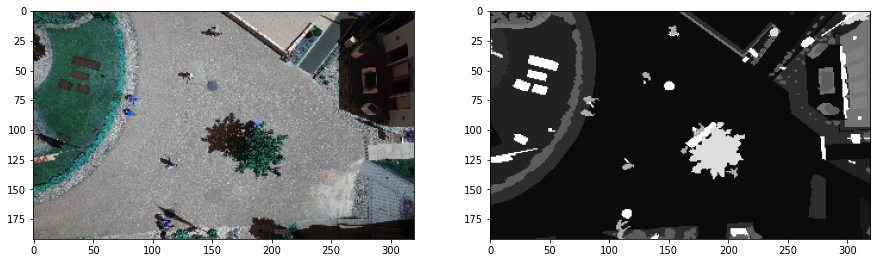

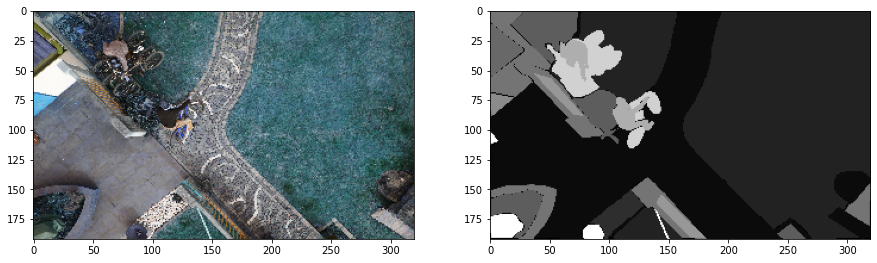

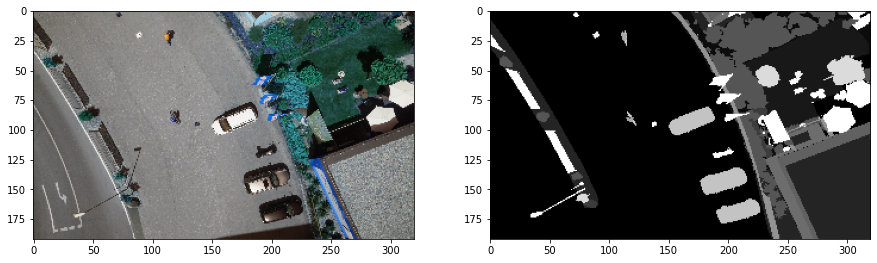

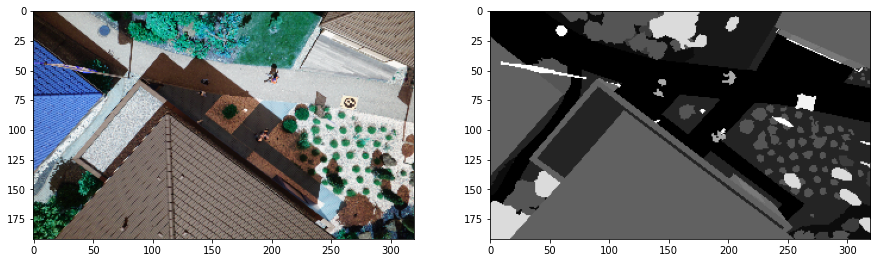

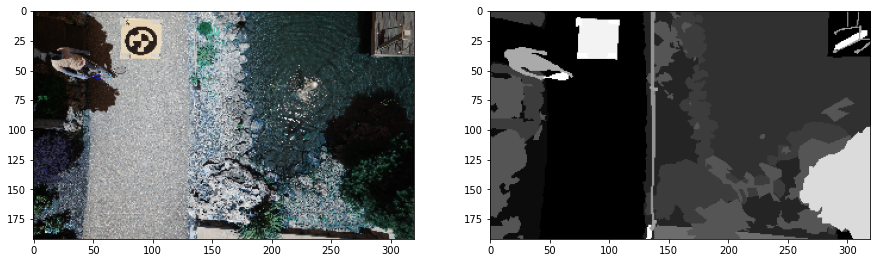

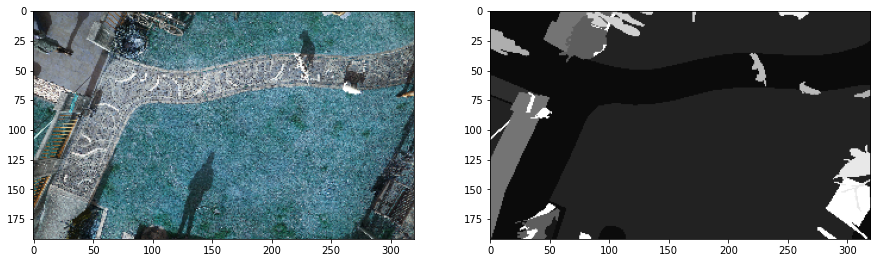

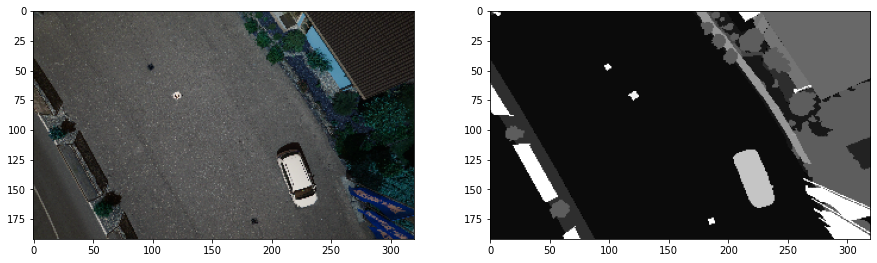

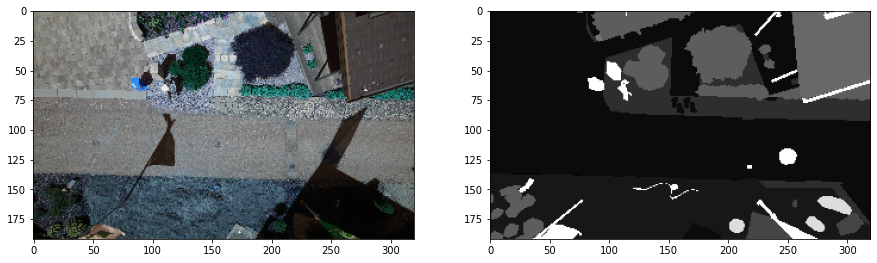

In [7]:
for i in range(10):
  display_images([images[i], labels[i]])

#Train, Test, Validation split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1)
X_train, X_val, Y_train, Y_val, = train_test_split(x_train, y_train, test_size=0.2)
X_train = X_train / 255.0
x_test = x_test / 255.0
X_val = X_val / 255.0

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(x_test.shape)
print(y_test.shape)


(288, 192, 320, 3)
(288, 192, 320)
(72, 192, 320, 3)
(72, 192, 320)
(40, 192, 320, 3)
(40, 192, 320)


#Model Development

In [ ]:
model_input = tf.keras.Input(shape=X_train[0].shape)
transfer_model = tf.keras.applications.VGG16(include_top=False, input_tensor=model_input, weights="imagenet")
# transfer_model.trainable = False

VGG16 model

In [ ]:
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 192, 320, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 160, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 160, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 160, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 80, 128)       0     

Extracting layers from VGG16 for encoder and creating decoder layers

In [ ]:
encoder_layers = [
               "block1_conv2",
               "block1_pool",
               "block2_conv2",
               "block2_pool",
               "block3_conv3",
               "block3_pool",
               "block4_conv3",
               "block4_pool",
               "block5_conv3",
               "block5_pool"
]

encoder_layers = [transfer_model.get_layer(name).output for name in encoder_layers]
encoder = tf.keras.Model(inputs=transfer_model.input, outputs=encoder_layers)
# encoder.trainable = False

decoder_layers = [tf.keras.layers.UpSampling2D(size=(2,2)) for i in range(len(encoder_layers)-6)]

10
4


##Function to build the U-net model

In [ ]:
def build_model():
  inputs = tf.keras.Input(shape=X_train[0].shape)
  x = inputs
  skip_connections = encoder(x)
  x = skip_connections[-1]
  skip_connections = skip_connections[:-1]
  skip_connections.reverse()
  skip_connections = [skip_connections[i] for i in range(len(skip_connections)) if i % 2 == 0]
  
  for i in range(len(decoder_layers)):
      x = decoder_layers[i](x)
      concat = tf.keras.layers.Concatenate()
      x = concat([x, skip_connections[i]])
      

  last = tf.keras.layers.Convolution2DTranspose(23,3,strides=2,padding='same')
  x = last(x)
  model = tf.keras.Model(inputs=inputs, outputs=x)
  return model

##Display the model architecture

In [ ]:
segmentation_model = build_model()
segmentation_model.summary()

[<KerasTensor: shape=(None, 12, 20, 512) dtype=float32 (created by layer 'model_23')>, <KerasTensor: shape=(None, 24, 40, 512) dtype=float32 (created by layer 'model_23')>, <KerasTensor: shape=(None, 48, 80, 256) dtype=float32 (created by layer 'model_23')>, <KerasTensor: shape=(None, 96, 160, 128) dtype=float32 (created by layer 'model_23')>, <KerasTensor: shape=(None, 192, 320, 64) dtype=float32 (created by layer 'model_23')>]
Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 192, 320, 3) 0                                            
__________________________________________________________________________________________________
model_23 (Functional)           [(None, 192, 320, 64 14714688    input_48[0][0]                   
______________________________________________________

Plot of the model architecture and skip connections

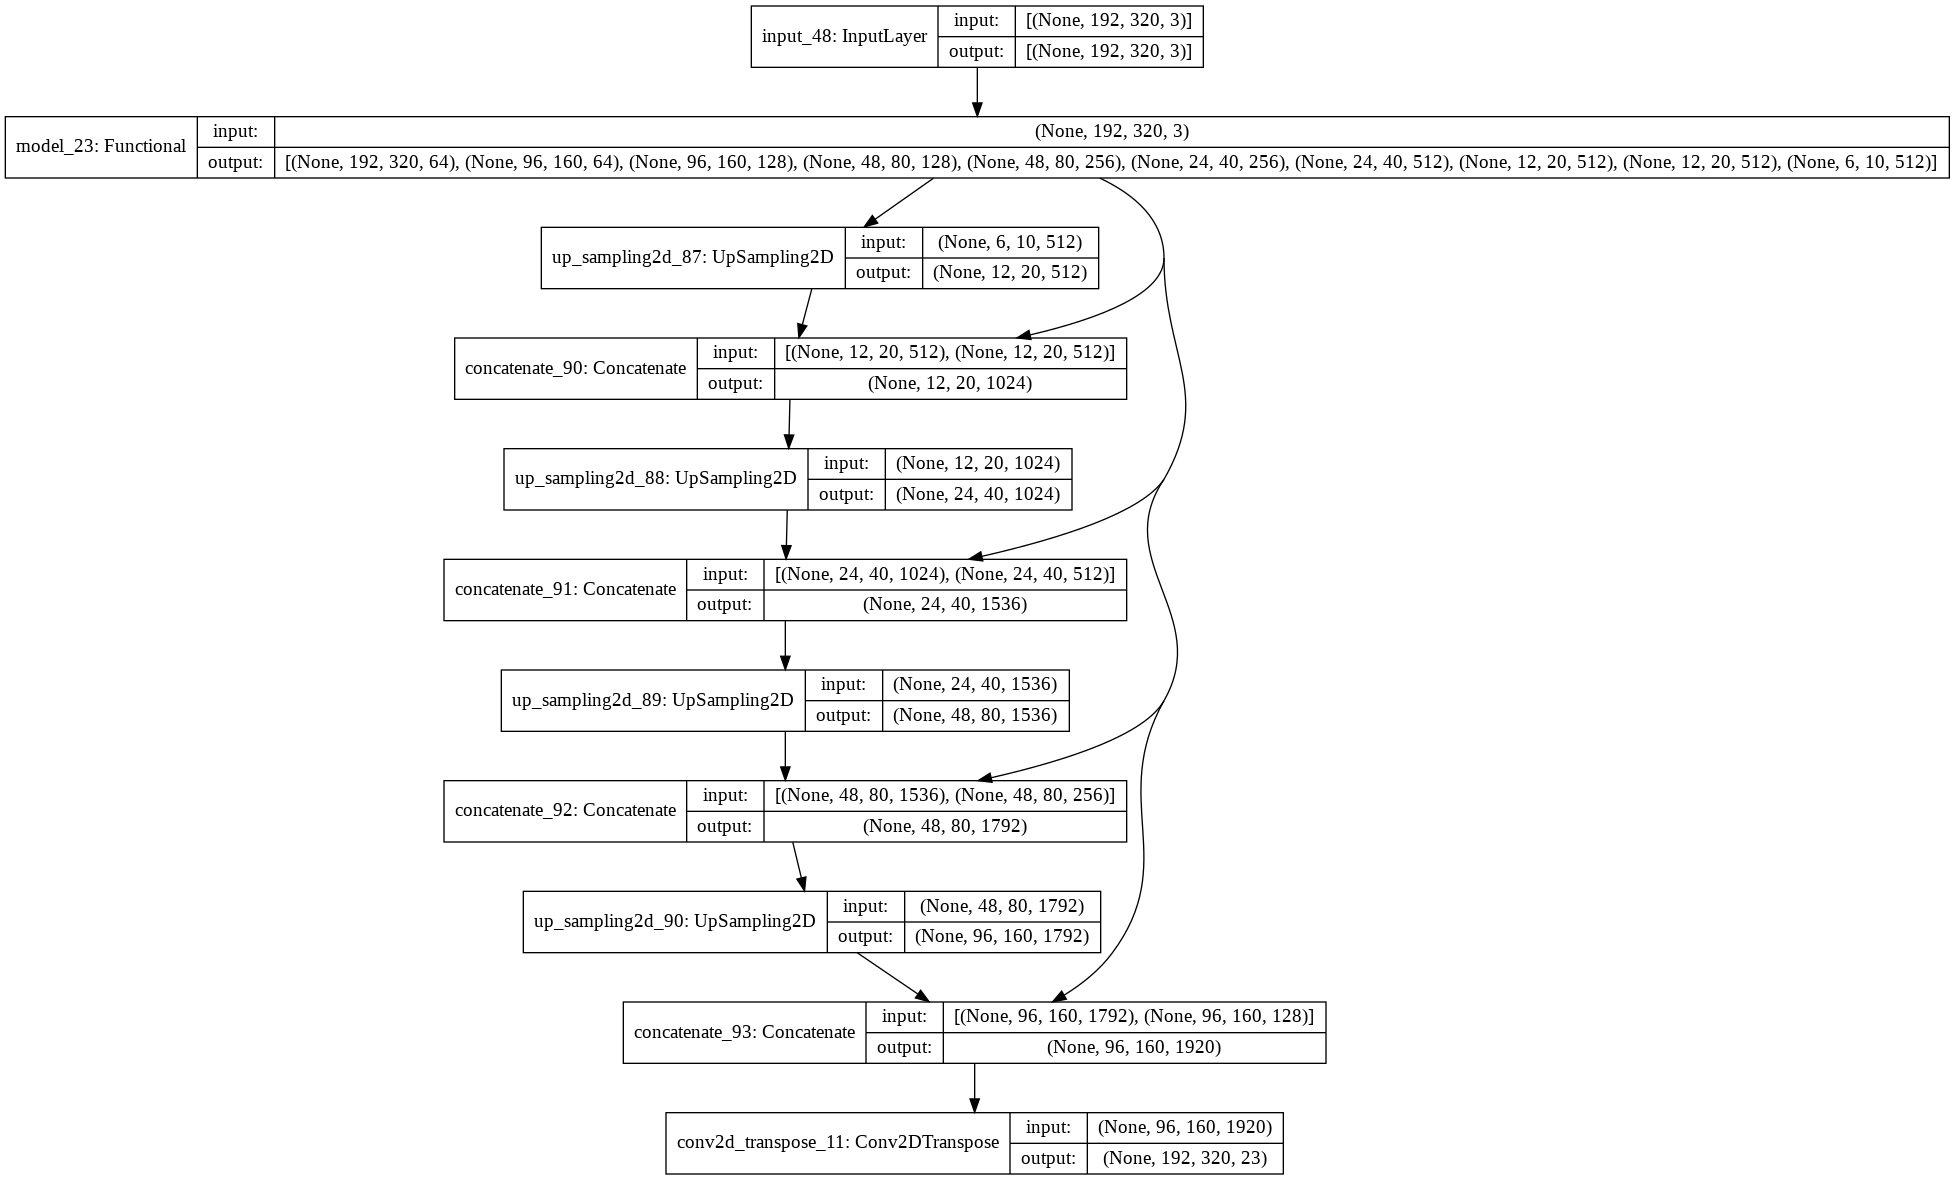

In [ ]:
tf.keras.utils.plot_model(segmentation_model, show_shapes=True)

Model compilation

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
segmentation_model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])

##Model Training

In [ ]:
hist = segmentation_model.fit(X_train, Y_train, batch_size=12, epochs=EPOCHS, validation_data=(X_val, Y_val), verbose=1)

Epoch 1/40
24/24 [==============================] - 14s 537ms/step - loss: 1.5313 - accuracy: 0.5906 - val_loss: 1.0582 - val_accuracy: 0.6919
Epoch 2/40
24/24 [==============================] - 13s 527ms/step - loss: 0.8219 - accuracy: 0.7587 - val_loss: 0.8680 - val_accuracy: 0.7406
Epoch 3/40
24/24 [==============================] - 13s 532ms/step - loss: 0.6801 - accuracy: 0.7936 - val_loss: 0.7747 - val_accuracy: 0.7620
Epoch 4/40
24/24 [==============================] - 12s 513ms/step - loss: 0.5626 - accuracy: 0.8247 - val_loss: 0.7040 - val_accuracy: 0.7865
Epoch 5/40
24/24 [==============================] - 12s 523ms/step - loss: 0.5037 - accuracy: 0.8429 - val_loss: 0.6813 - val_accuracy: 0.7954
Epoch 6/40
24/24 [==============================] - 12s 521ms/step - loss: 0.4660 - accuracy: 0.8540 - val_loss: 0.6761 - val_accuracy: 0.7991
Epoch 7/40
24/24 [==============================] - 12s 523ms/step - loss: 0.4590 - accuracy: 0.8562 - val_loss: 0.6560 - val_accuracy: 0.8099

##Plot the learning curve of the model

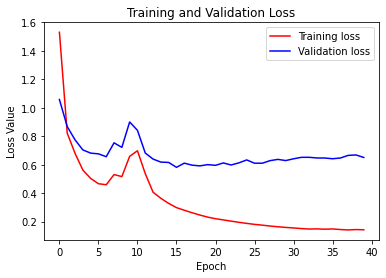

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

##Save model

In [ ]:
segmentation_model.save('/content/gdrive/Shareddrives/SEP_769/group2_vgg_segmentation.h5')

#Predictions on the test set and google maps images

##Load Model

In [143]:
model = None
if os.path.exists("/content/gdrive/Shareddrives/SEP_769/group2_vgg_segmentation.h5"):
  model = tf.keras.models.load_model('/content/gdrive/Shareddrives/SEP_769/group2_vgg_segmentation.h5')
model.summary()

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 192, 320, 3) 0                                            
__________________________________________________________________________________________________
model_23 (Functional)           [(None, 192, 320, 64 14714688    input_48[0][0]                   
__________________________________________________________________________________________________
up_sampling2d_87 (UpSampling2D) (None, 12, 20, 512)  0           model_23[0][9]                   
__________________________________________________________________________________________________
concatenate_90 (Concatenate)    (None, 12, 20, 1024) 0           up_sampling2d_87[0][0]           
                                                                 model_23[0][8]            

In [145]:
predictions = model.predict(x_test)

##Function to process the Network output

In [146]:
def create_mask(pred):
  mask = np.argmax(pred, axis=-1)
  mask = mask[..., np.newaxis]
  return mask

In [147]:
predictions_processed = np.array([create_mask(predictions[i]) for i in range(len(predictions))])

In [148]:
print(predictions_processed.shape)
print(np.squeeze(predictions_processed).shape)
predictions_processed = np.squeeze(predictions_processed)

(40, 192, 320, 1)
(40, 192, 320)


##Display True labels and predicted labels of the test set

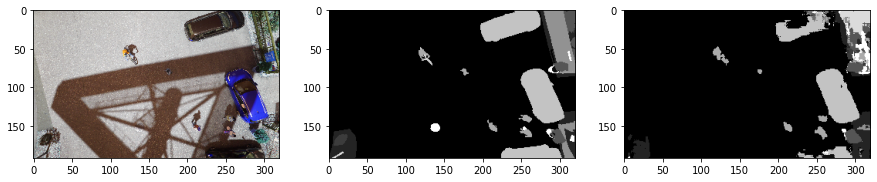

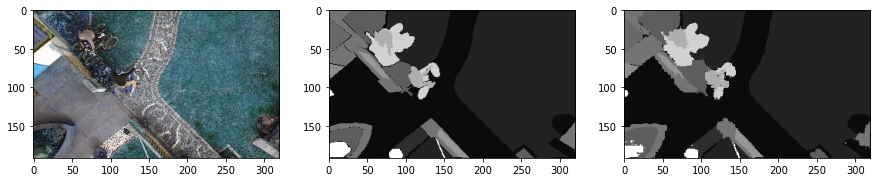

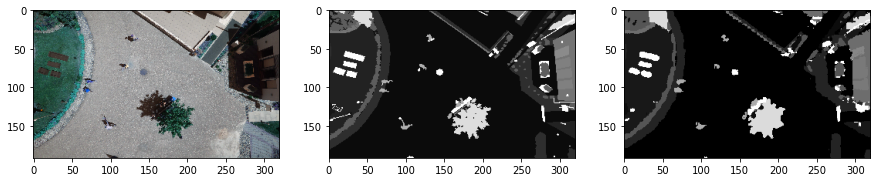

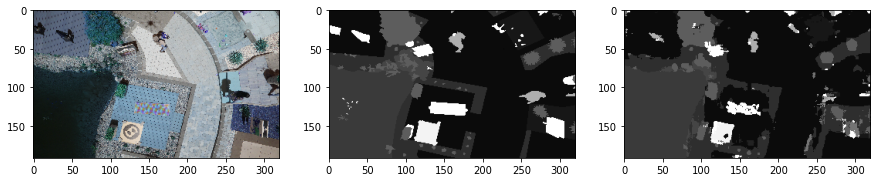

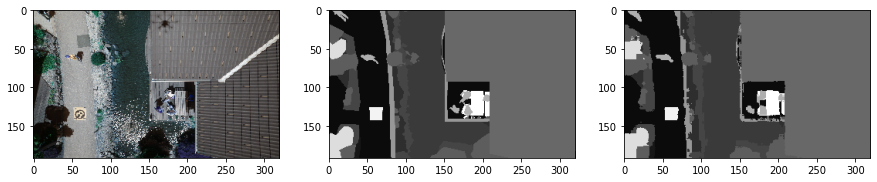

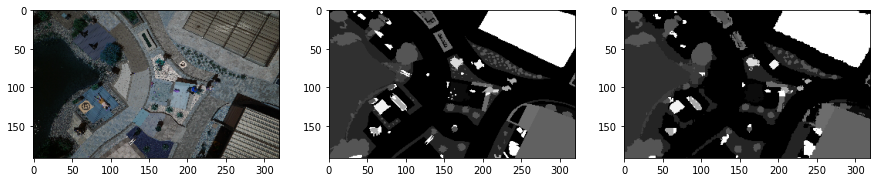

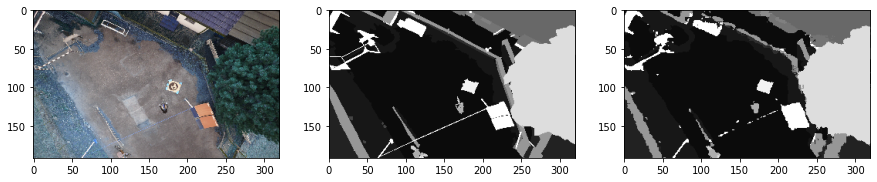

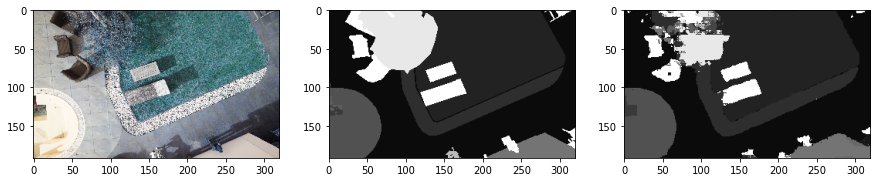

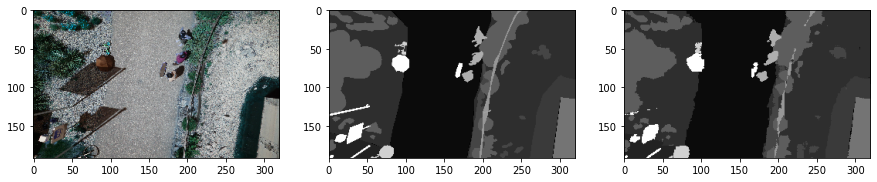

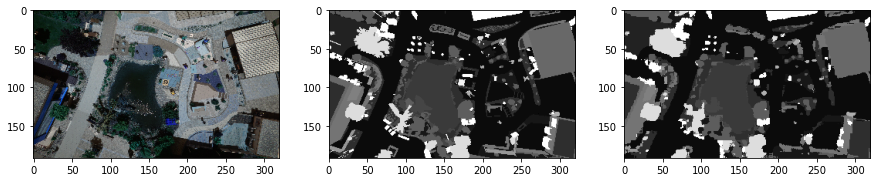

In [149]:
for i in range(10):
  display_images([x_test[i], y_test[i], predictions_processed[i]])

(192, 320, 3)


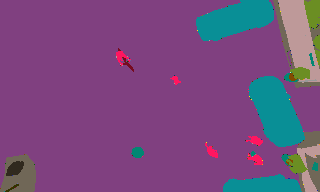

In [151]:
colour_label = labels_to_colour(y_test[0])
colour_label = colour_label.astype(int)
cv2_imshow(colour_label)

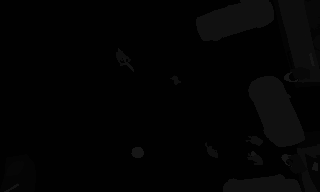

In [131]:
cv2_imshow(y_test[0])

##Mean IOU

In [152]:
iou = tf.keras.metrics.MeanIoU(num_classes=23)
iou.update_state(y_test, predictions_processed)
iou.result().numpy()

0.6206446

##Pixel Accuracy

In [153]:
pixel_err = np.sum(predictions_processed != y_test)
print(pixel_err)
print(y_test.size)
print(pixel_err / y_test.size)
pixel_accuracy = 1 - pixel_err / y_test.size
print(f'Pixel Accuracy: {round(pixel_accuracy * 100, 1)}%')

205901
2457600
0.08378133138020834
Pixel Accuracy: 91.6%


##Load google maps images

In [22]:
gmaps_images = images_to_array("/content/gdrive/Shareddrives/SEP_769/google_maps_imgs/", width=WIDTH, height=HEIGHT, ext='PNG')
gmaps_images = gmaps_images / 255.0

Predict labels from google maps images

In [140]:
g_maps_predictions = model.predict(gmaps_images)
g_maps_predictions = np.array([create_mask(g_maps_predictions[i]) for i in range(len(g_maps_predictions))])
g_maps_predictions = np.squeeze(g_maps_predictions)
g_maps_predictions_colour = np.array([labels_to_colour(g_maps_predictions[i]) for i in range(len(g_maps_predictions))])
print(g_maps_predictions.shape)
print(g_maps_predictions_colour.shape)

(192, 320, 3)
(192, 320, 3)
(192, 320, 3)
(192, 320, 3)
(192, 320, 3)
(5, 192, 320)
(5, 192, 320, 3)


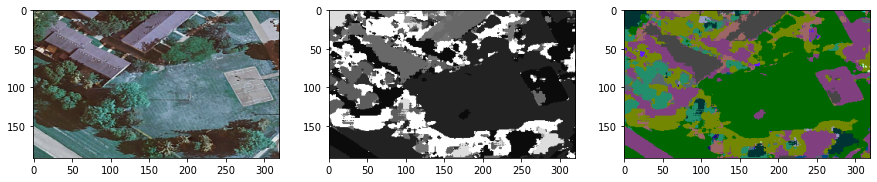

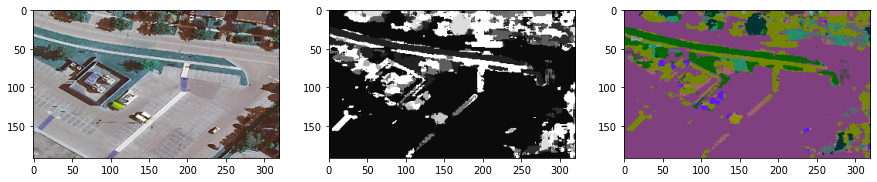

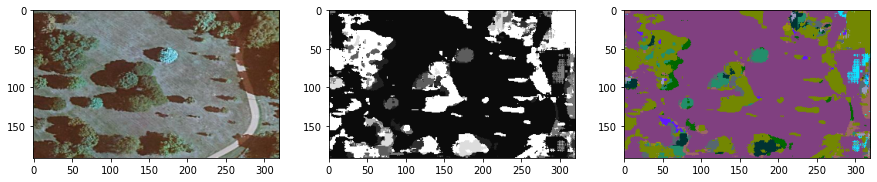

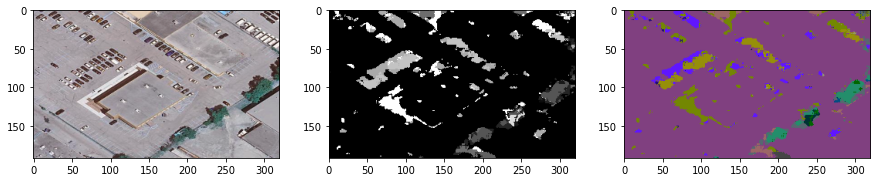

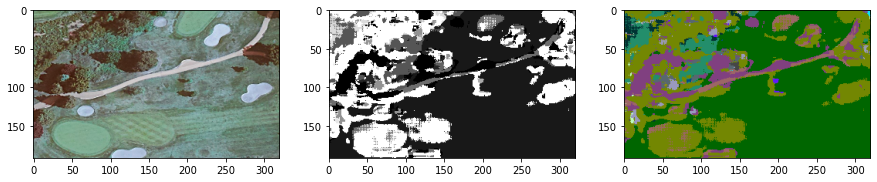

In [141]:
for i in range(len(gmaps_images)):
  display_images([gmaps_images[i],g_maps_predictions[i], g_maps_predictions_colour[i]])